In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='ae1a755d-e162-4f07-9f5a-130d2280e78e', project_access_token='p-aa90b9b21de435c3f4c94494a24b5c5e69d030f8')
pc = project.project_context

# Extracting entities in hotel reviews using Watson NLP

This notebook demonstrates how to train text classifiers using Watson NLP. The classifiers predicts the complaints from the text of a customer reviews. This could be used, for example to route a complaint to the appropriate staff member.

The data that is used in this notebook is the data scraped from Booking.com. This dataset contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe. A reviews contains the customer’s narrative description of their experience. In this notebook, you will focus on classifying the reviews as complaints that contain this narrative description to show how to use Watson NLP.

The data is sourced from the publicly available [Kaggle 515K Hotel Reviews Data in Europe](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe) and [OpinRank Review Dataset](https://archive.ics.uci.edu/ml/datasets/OpinRank+Review+Dataset). The dataset used in this notebook has combined and transformed both datasets for a cleaner and simpler approach to the data preparation step.


## What you'll learn in this notebook

Watson NLP implements state-of-the-art classification algorithms from three different families: 
- Classic machine learning using SVM (Support Vector Machines)
- Deep learning using CNN (Convolutional Neural Networks)
- A transformer-based algorithm using the Google BERT multilingual model 

Watson NLP also offers an easy to use _ensemble classifier_ which combines different classification algorithms and a majority voting.

In this notebook, you'll learn how to:

- **Explore a Rule Based model** using `watson_nlp.blocks.entity_mentions.RBR`. RBR stands for Rule Based. The RBR block does not depend on any blocks so the raw document text can be directly input to the model. The RBR handles syntactically regular entity types such as number, email and phone.
- **Explore a BiLSTM** using `watson_nlp.blocks.entity_mentions.BiLSTM`. BiLSTM stands for Bidirectional LSTM. The BiLSTM model uses GloVe embeddings trained on the Wikipedia corpus in each language.
- **Explore a BERT** using `watson_nlp.blocks.entity_mentions.BERT`. BERT stands for Bidirectional Encoder Representations from Transformers. BERT model uses the Google Multilingual BERT model, meaning that a single model can analyze input texts from multiple languages.
- **Explore a Keyword Text Rank** using `watson_nlp.blocks.keywords.TextRank`. The keywords block ranks noun phrases extracted from an input document based on how relevant they are within the document. 
- **Analyze Sentiment in Entity Mentions** using `watson_nlp.blocks.sentiment.SentenceSentimentBERT`. 


## Table of Contents


1.	[Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Entity Extraction](#entity)
    1. [Entity extraction functions](#functions)
    1. [Run entity extraction](#run)
    1. [Hotel Comparison](#hotel)
    1. [Website Comparison](#website)
1.  [Keyword Extraction](#keyword)
1.  [Target Sentiment Analysis](#targetSentiment)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _DO + NLP Runtime 22.1 on Python 3.9_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [2]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud
!pip install ibm-watson

In [3]:
# Silence Tensorflow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [4]:
import json
import pandas as pd
from time import process_time
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import watson_nlp

<a id="loadData"></a>
## 2. Data Loading (hotel review/customer complaint data)

In [5]:
belgrave = project.get_file('uk_england_london_belgrave_hotel.csv')
belgrave_df = pd.read_csv(belgrave)

In [6]:
euston = project.get_file('uk_england_london_euston_square_hotel.csv')
euston_df = pd.read_csv(euston)

In [7]:
dorset = project.get_file('uk_england_london_dorset_square.csv')
dorset_df = pd.read_csv(dorset)

In [8]:
# preview the one of the DataFrames
dorset_df.head()

,date,text,website,hotel
0,2017-07-13,Although I appreciate this is a 4 star and not a 5 star it is nowhere near the standard of the other Firmdale hotels we have stayed at Room we had looked over a busy road not the leafy garden square and had just a shower no bath Very friendly staff good cocktails in bar,Booking.com,Dorset
1,2017-06-26,A night time bottle of water on the second night or something similar Beautiful furnishings comfortable bed gorgeous view of Dorset Square very pleasant staff,Booking.com,Dorset
2,2017-06-12,Our room was very small and had no view Tea and coffee facilities in the room would be an added bonus The hotel is beautifully decorated The staff was very friendly and accommodating The restaurant had a good breakfast selection I can definitely recommend the hotel to anybody who would like a boutique hotel experience The hotel is within walking distance from Lords cricket grounds The mini ...,Booking.com,Dorset
3,2017-06-06,The bed was a bit small and short given that we are rather tall people Even though we thoroughly enjoyed breakfast the selection could have benefitted from also some more savoury items next to the egg varieties such as some cheese cold cuts Nothing really to find fault with Overall a very well maintained property Beautiful room although a bit small with a nice view of the square Equally bea...,Booking.com,Dorset
4,2017-05-29,We didnt like our first room but the staff traded our room when we asked They were as helpful as they could be while being totally booked up We loved the location as well as the staff Lorenzo and Sarah from the front desk were incredibly helpful as well as Virgil and all the others we had a wonderful time,Booking.com,Dorset


<a id="entity"></a>
## 3. Entity extraction

<a id="function"></a>
### 3a. Entity extraction function

In [9]:
# Load a syntax model to split the text into sentences and tokens
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
# Load bilstm model in WatsonNLP
bilstm_model = watson_nlp.load(watson_nlp.download('entity-mentions_bilstm_en_stock'))
# Load rbr model in WatsonNLP
rbr_model = watson_nlp.load(watson_nlp.download('entity-mentions_rbr_en_stock'))
# Load bert model in WatsonNLP
bert_model = watson_nlp.load(watson_nlp.download('entity-mentions_bert_multi_stock'))
# Load transformer model in WatsonNLP
#transformer_model = watson_nlp.load(watson_nlp.download('entity-mentions_transformer_multi_stock'))

In [10]:
def extract_entities(data, model, hotel_name, website):
    text = str(data)
    if model == 'rbr':
        # Run rbr model on text
        mentions = rbr_model.run(text)
    else:
        # Run syntax model on text 
        syntax_result = syntax_model.run(text)
        if model == 'bilstm':
            # Run bilstm model on syntax result
            mentions = bilstm_model.run(syntax_result)
        elif model == 'bert':
            # Run bert model on syntax result
            mentions = bert_model.run(syntax_result)
        elif model == 'transformer':
            # Run transformer model on syntax result
            mentions = transformer_model.run(syntax_result)
            
    entities_list = mentions.to_dict()['mentions']
    ent_list=[]
    for i in range(len(entities_list)):
        ent_type = entities_list[i]['type']
        ent_text = entities_list[i]['span']['text'] 
        ent_list.append({'ent_type':ent_type,'ent_text':ent_text})
        
    if len(ent_list) > 0:
        return {'Document':text,'Hotel Name':hotel_name,'Website':website,'Entities':ent_list}
    else:
        return {}

Stop-words are common words that are unmeaningful for separating the data. Such common words are assumed to be "noise" as their high frequency could hide the words carrying more informative signal. We filter   them based on a pre-defined list used in WatsonNLP and based on the part-of-speech. Notes:

1. The stop-words list can be customized for the target dataset. We demonstrate this below.
1. When we vectorize the documents below, we apply a filter that ignores terms that appear in 50% or more of the documents. This filter can also be counted as part of stop-words filtering.

In [11]:
wnlp_stop_words = watson_nlp.download_and_load('text_stopwords_classification_ensemble_en_stock').stopwords
stop_words = list(wnlp_stop_words)
stop_words.remove('keep')
stop_words.extend(["gimme", "lemme", "cause", "'cuz", "imma", "gonna", "wanna", 
                   "gotta", "hafta", "woulda", "coulda", "shoulda", "howdy","day", 
                   "first", "second", "third", "fourth", "fifth", "London", "london", 
                   "1st", "2nd", "3rd", "4th", "5th", 
                   "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", 
                   "weekend", "week", "evening", "morning"])

In [12]:
# Pre-processing steps 
import string
exclude = set(string.punctuation)
def clean(doc):
    # replacing &amp to & as it is HTML tag
    stop_free = " ".join([word.replace("&amp", "&") for word in doc.split() if word.lower() not in stop_words]).lower()
    return stop_free

<a id="run"></a>
### 3b. Run entity extraction

In [13]:
hotels_df_list = [belgrave_df, euston_df, dorset_df]

In [14]:
def run_extraction(df_list, text_col, extract_entities):
    extract_list = []
    for df in df_list:
        all_text = dict(zip(df[text_col], zip(df['hotel'], df['website'])))
        all_text_clean = {clean(doc[0]): doc[1] for doc in all_text.items()}
        for text in all_text_clean.items():
            # change the second parameter to 'rbr', 'bilstm', or 'bert' to try other models
            extract_value = extract_entities(text[0], 'bilstm', text[1][0], text[1][1])
            if len(extract_value) > 0:
                extract_list.append(extract_value)              
    return extract_list

In [15]:
extract_list = run_extraction(hotels_df_list, 'text', extract_entities)

In [16]:
analysis_df=pd.DataFrame(columns=['Document','Hotel Name', 'Website', 'Entities'])
analysis_df=analysis_df.append(extract_list,ignore_index = True)
analysis_df.head()

,Document,Hotel Name,Website,Entities
0,windows thin room driveways side pretty hear room didn refrigerator breakfast excellent rooms thought close victorias station pimlico line good soundproof rooms,Belgrave,Booking.com,"[{'ent_type': 'Facility', 'ent_text': 'victorias station pimlico line good soundproof rooms'}]"
1,great central location walking distance victoria pimlico hotel fresh clean lovely continental breakfast return price,Belgrave,Booking.com,"[{'ent_type': 'Organization', 'ent_text': 'distance victoria pimlico hotel'}]"
2,room clean small nice breakfast bit rushed arrived 9 05am advised needed quickly buffet cleared 9 30am promptly,Belgrave,Booking.com,"[{'ent_type': 'Time', 'ent_text': '9 05am'}, {'ent_type': 'Time', 'ent_text': '9 30am'}]"
3,didn book longer stay wonderful hotel wonderful staff wonderful room wonderful stay absolutely perfect staying visit belgrave,Belgrave,Booking.com,"[{'ent_type': 'Location', 'ent_text': 'belgrave'}]"
4,booked executive double nice view don expecting spacious request fresh towels room cleaned wouldn happened hadn asked stay 2 nights great location nice places eat hotel short walk tube station decent 20mins walk buckingham palace nice view top floor bedrooms,Belgrave,Booking.com,"[{'ent_type': 'Facility', 'ent_text': 'walk tube station decent 20mins walk buckingham palace'}]"


In [17]:
exp_entities = analysis_df.explode('Entities')

In [18]:
entities_df = pd.concat([exp_entities.drop('Entities', axis=1), exp_entities['Entities'].apply(pd.Series)], axis=1)

<a id="hotel"></a>
### 3c. Comparing top 20 entities for each hotel

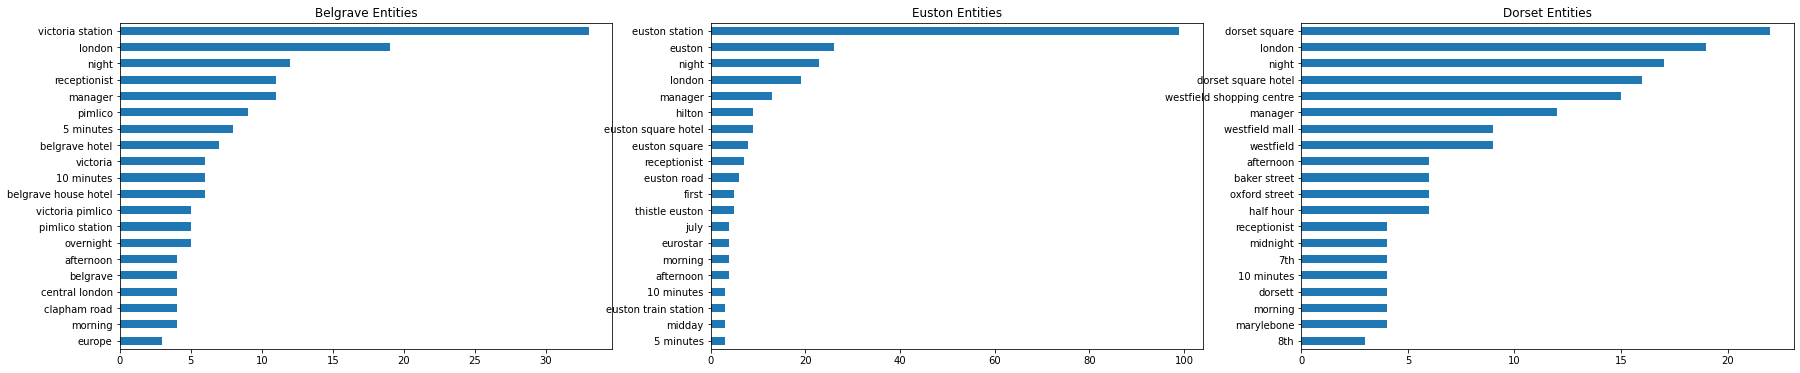

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
entities_df[entities_df['Hotel Name'] == 'Belgrave']['ent_text'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[0], title='Belgrave Entities')
entities_df[entities_df['Hotel Name'] == 'Euston']['ent_text'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[1], title='Euston Entities') 
entities_df[entities_df['Hotel Name'] == 'Dorset']['ent_text'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[2], title='Dorset Entities') 

plt.show()

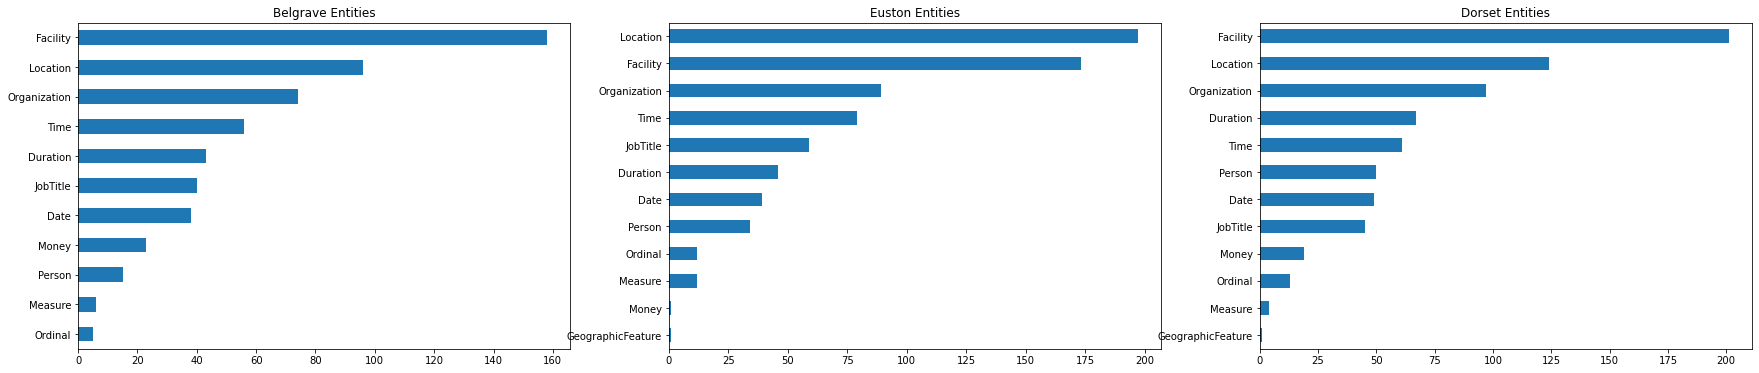

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
entities_df[entities_df['Hotel Name'] == 'Belgrave']['ent_type'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[0], title='Belgrave Entities')
entities_df[entities_df['Hotel Name'] == 'Euston']['ent_type'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[1], title='Euston Entities') 
entities_df[entities_df['Hotel Name'] == 'Dorset']['ent_type'].value_counts().head(20).sort_values().plot(kind='barh', ax=axs[2], title='Dorset Entities') 

plt.show()

In [21]:
# Entities for Belgrave Hotel where the entity type is Facility
entities_df[(entities_df['Hotel Name'] == 'Belgrave') & (entities_df['ent_type'] == 'Facility')]['ent_text']

0        victorias station pimlico line good soundproof rooms
4      walk tube station decent 20mins walk buckingham palace
8                         pimlico station tv english channels
13                                      pimlico station hotel
17                                           victoria station
                                ...                          
281                                        london.worst hotel
281                     there.though mentionned website hotel
283                          station bus station tube station
289                                      belgrave house hotel
290          hotel iswithin walking distance victoria station
Name: ent_text, Length: 158, dtype: object

In [22]:
def create_word_cloud(top_level_cat_df, text):
    figure, ax1 = plt.subplots(ncols=1, figsize=(10,6))
    wc = WordCloud(width=600, height=400, background_color ='white').generate_from_frequencies(top_level_cat_df.value_counts().head(20))
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    ax1.title.set_text(text)
    plt.show()
    
def create_word_cloud_list(df_list, text, name_list):
    figure, ax1 = plt.subplots(ncols=len(df_list), figsize=(10*len(df_list),6))
    for i in range(0, len(df_list)):
        wc = WordCloud(width=600, height=400, background_color ='white').generate_from_frequencies(df_list[i].value_counts().head(20))
        ax1[i].imshow(wc, interpolation="bilinear")
        ax1[i].axis('off')
        ax1[i].title.set_text(name_list[i] + ' ' + text)
    plt.show()

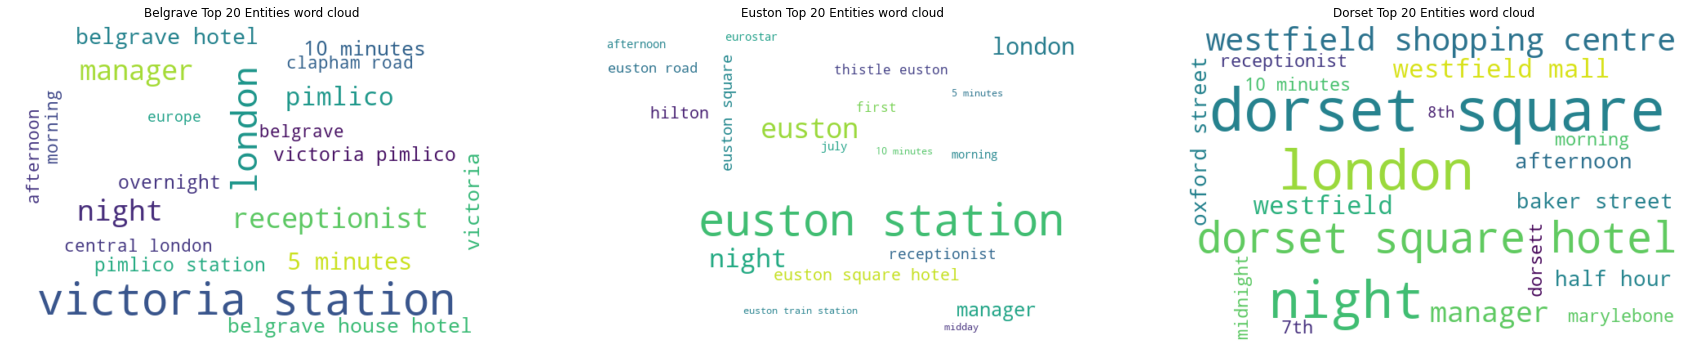

In [23]:
df_list = [entities_df[entities_df['Hotel Name'] == 'Belgrave']['ent_text'], 
           entities_df[entities_df['Hotel Name'] == 'Euston']['ent_text'], 
           entities_df[entities_df['Hotel Name'] == 'Dorset']['ent_text']]
name_list = ['Belgrave', 'Euston', 'Dorset']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

<a id="website"></a>
### 3d. Comparison between booking.com vs tripadvisor for one hotel

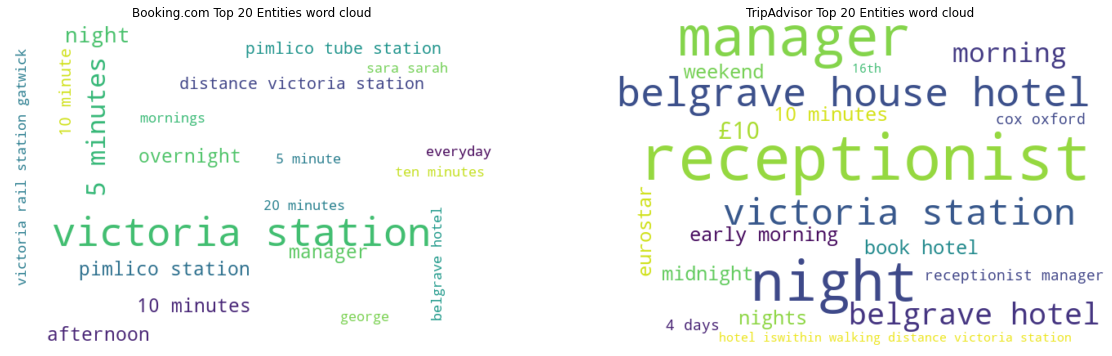

In [24]:
df_list = [entities_df[(entities_df['Hotel Name'] == 'Belgrave') & (entities_df['Website'] == 'Booking.com') & (entities_df['ent_type'] != 'Location')]['ent_text'], 
           entities_df[(entities_df['Hotel Name'] == 'Belgrave') & (entities_df['Website'] == 'TripAdvisor') & (entities_df['ent_type'] != 'Location')]['ent_text']]
name_list = ['Booking.com', 'TripAdvisor']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

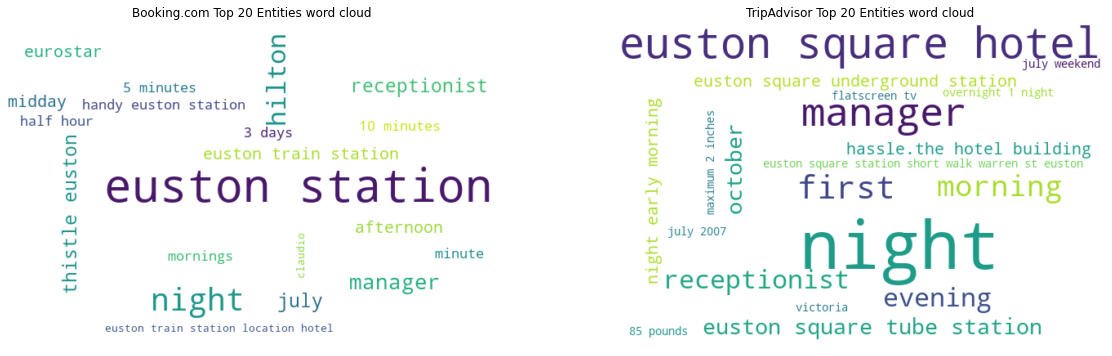

In [25]:
df_list = [entities_df[(entities_df['Hotel Name'] == 'Euston') & (entities_df['Website'] == 'Booking.com') & (entities_df['ent_type'] != 'Location')]['ent_text'], 
           entities_df[(entities_df['Hotel Name'] == 'Euston') & (entities_df['Website'] == 'TripAdvisor') & (entities_df['ent_type'] != 'Location')]['ent_text']]
name_list = ['Booking.com', 'TripAdvisor']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

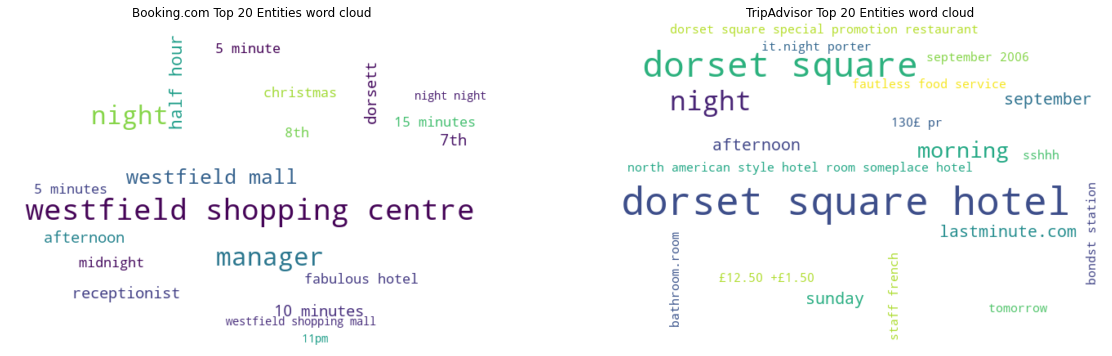

In [26]:
df_list = [entities_df[(entities_df['Hotel Name'] == 'Dorset') & (entities_df['Website'] == 'Booking.com') & (entities_df['ent_type'] != 'Location')]['ent_text'], 
           entities_df[(entities_df['Hotel Name'] == 'Dorset') & (entities_df['Website'] == 'TripAdvisor') & (entities_df['ent_type'] != 'Location')]['ent_text']]
name_list = ['Booking.com', 'TripAdvisor']
create_word_cloud_list(df_list, "Top 20 Entities word cloud", name_list)

<a id="keyword"></a>
## 4. Keyword extraction

In [27]:
# Keyword Extraction
# Load Noun Phrases, Embedding and Keywords models for English
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
noun_phrases_model = watson_nlp.load(watson_nlp.download('noun-phrases_rbr_en_stock'))
keywords_model = watson_nlp.load(watson_nlp.download('keywords_text-rank_en_stock'))
use_model = watson_nlp.load(watson_nlp.download("embedding_use_en_stock"))
embed_model = watson_nlp.load(watson_nlp.download('keywords_embed-rank_multi_stock'))

In [28]:
from watson_nlp import data_model as dm
import time
def extract_keywords(text):
    # Run the Syntax and Noun Phrases models
    syntax_prediction = syntax_model.run(text, parsers=('token', 'lemma', 'part_of_speech'))
    noun_phrases = noun_phrases_model.run(text)
    # Run the keywords model
    keywords = keywords_model.run(syntax_prediction, noun_phrases, limit=5)  
    keywords_list =keywords.to_dict()['keywords']
    key_list=[]
    for i in range(len(keywords_list)):
        key_list.append(keywords_list[i]['text'])
    return {'Keywords':key_list}

In [29]:
top_doc_list =[]
for index, row in analysis_df.iterrows():
    if row['Hotel Name'] == 'Euston':
        top_doc_list.append(row['Document'])      

In [30]:
keywords = [extract_keywords(doc) for doc in top_doc_list] 
keywords_df = pd.DataFrame(keywords)
exp_keywords = keywords_df.explode('Keywords')

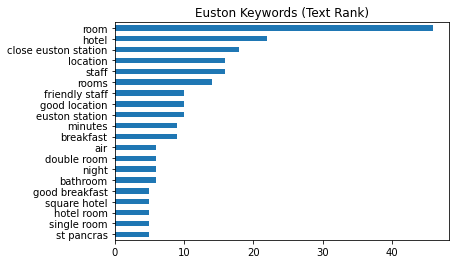

In [31]:
exp_keywords['Keywords'].value_counts().head(20).sort_values().plot(kind='barh', title='Euston Keywords (Text Rank)') 
plt.show()

<a id="targetSentiment"></a>
## 5. Target sentiment analysis

In [32]:
sentiment_extraction_model = watson_nlp.load(watson_nlp.download('targets-sentiment_sequence-bert_multi_stock'))

In [33]:
def run_sentiment(df, text_col, ent_col):
    pos_targets =[]
    neg_targets =[]
    entities = dict(df[ent_col].value_counts().head(20).sort_values())
    for text in df[df[ent_col].isin(entities.keys())][text_col]:
        #print(text)
        # Get Tokens 
        syntax_analysis_en = syntax_model.run(text, parsers=('token',))
        extracted_sentiments = sentiment_extraction_model.run(syntax_analysis_en)
        # print(extracted_sentiments.to_dict())
        for key , score in extracted_sentiments.to_dict()['targeted_sentiments'].items():
            label = score['label']
            if label=='SENT_POSITIVE': # and key not in pos_targets:
                pos_targets.append(key)
            elif label=='SENT_NEGATIVE': # and key not in neg_targets:
                neg_targets.append(key)
            # print(key, "\t",score['score'] ,"\t",score['label'] )
    return pos_targets, neg_targets

In [34]:
pos_targets_belgrave, neg_targets_belgrave = run_sentiment(entities_df[entities_df['Hotel Name'] == 'Belgrave'], 'Document', 'ent_text')
pos_targets_euston, neg_targets_euston = run_sentiment(entities_df[entities_df['Hotel Name'] == 'Euston'], 'Document', 'ent_text')
pos_targets_dorset, neg_targets_dorset = run_sentiment(entities_df[entities_df['Hotel Name'] == 'Dorset'], 'Document', 'ent_text')

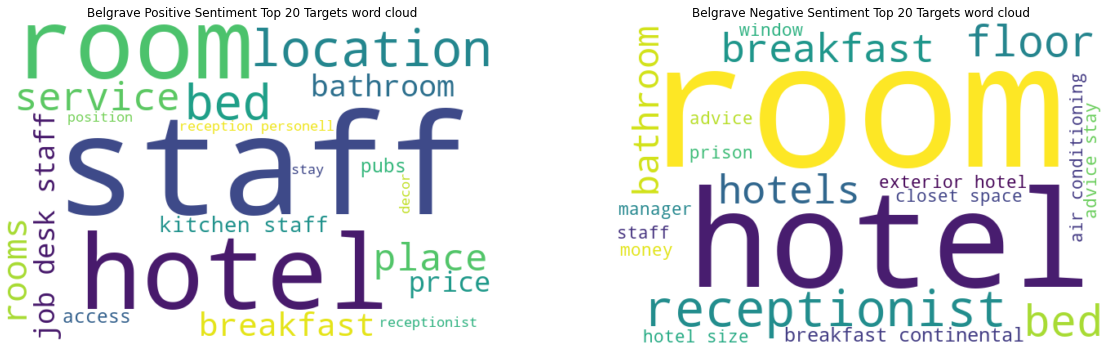

In [35]:
create_word_cloud_list([pd.DataFrame(pos_targets_belgrave)[0], pd.DataFrame(neg_targets_belgrave)[0]], "Sentiment Top 20 Targets word cloud", ['Belgrave Positive', 'Belgrave Negative'])

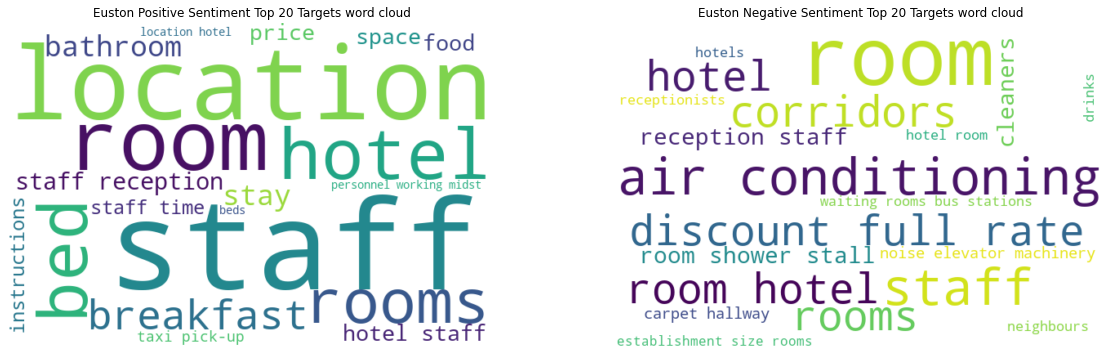

In [36]:
create_word_cloud_list([pd.DataFrame(pos_targets_euston)[0], pd.DataFrame(neg_targets_euston)[0]], "Sentiment Top 20 Targets word cloud", ['Euston Positive', 'Euston Negative'])

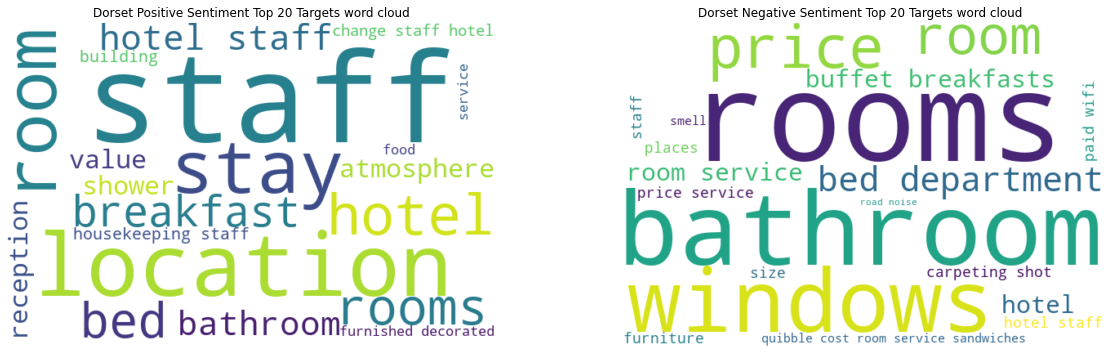

In [37]:
create_word_cloud_list([pd.DataFrame(pos_targets_dorset)[0], pd.DataFrame(neg_targets_dorset)[0]], "Sentiment Top 20 Targets word cloud", ['Dorset Positive', 'Dorset Negative'])

## 6. Summary